In [1]:
    #General
import pandas as pd
import numpy as np


    #Plotting
import matplotlib.pyplot as plt
import seaborn as sns


    #Sklearn Packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.feature_extraction import stop_words, text
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

    #Import/Export variables and models
import dill as pickle

%config InlineBackend.figure_format = 'retina'

**Reading in DataFrame**

In [3]:
df = pd.read_csv('./2_for_modeling_df.csv')

## Preprocessing

#### Transforming Data With FunctionTransformer

In [4]:
get_text_data = FunctionTransformer(lambda x: x['all_text'], validate = False)
get_numeric_data = FunctionTransformer(lambda x: x[['count', 'sentiment']], validate = False)

## Modeling

#### Instantiating our X and y variables

In [5]:
y = df['subreddit_target']
X = df[['sentiment', 'all_text', 'count']]

#### Train Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   random_state=42)

## Logicstic Regression

Building a Pipeline to Grid Search Using Standard Scaler, Count Vectorizer

In [7]:
pipe_logreg = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer())
            ]))
    ])),
    ('logreg', LogisticRegression(solver='liblinear'))
])

params_logreg = {
           'logreg__penalty' : ['l1', 'l2']
}

gs_logreg = GridSearchCV(pipe_logreg, params_logreg, cv=5)

gs_logreg.fit(X_train, y_train)
print("train score", gs_logreg.score(X_train, y_train))
print("test score", gs_logreg.score(X_test, y_test))
print("best params:", gs_logreg.best_params_)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


train score 0.8817888427846934
test score 0.6764380530973452
best params: {'logreg__penalty': 'l2'}


## KNN

In [8]:
pipe_knn = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer())
            ]))
    ])),
    ('knn', KNeighborsClassifier())

])

params_knn = {
    'knn__n_neighbors' : [3, 5, 10, 15, 20],
#     'knn__metric': ['euclidean', 'manhattan']  #Takes a while to run

}

gs_knn = GridSearchCV(pipe_knn, params_knn, cv=5)

gs_knn.fit(X_train, y_train)
print("train score:", gs_knn.score(X_train, y_train))
print("test score", gs_knn.score(X_test, y_test))
print("best params:", gs_knn.best_params_)

train score: 0.6790225910557861
test score 0.5873893805309734
best params: {'knn__n_neighbors': 10}


## Decision Tree

In [9]:
pipe_dt = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer())
            ]))
    ])),
    ('dt', DecisionTreeClassifier(random_state = 42))

])

params_dt = {
    'dt__max_depth': [3, 5],  
    'dt__min_samples_split': [3, 5, 7],
    'dt__min_samples_leaf': [3, 5], 
#     'dt__random_state': 42
#     'knn__n_neighbors' : [3, 5, 10, 15, 20]
#             'cvec__stop_words' : [None, 'english'],
#            'logreg__penalty' : ['l1', 'l2']
}

gs_dt = GridSearchCV(pipe_dt, params_dt, cv=5)

gs_dt.fit(X_train, y_train)
print("train score:", gs_dt.score(X_train, y_train))
print("test score:", gs_dt.score(X_test, y_test))
print("best params:", gs_dt.best_params_)

train score: 0.6566159520516367
test score: 0.6493362831858407
best params: {'dt__max_depth': 5, 'dt__min_samples_leaf': 3, 'dt__min_samples_split': 3}


## Random Forest

In [11]:
pipe_rf = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer())
            ]))
    ])),
    ('rf', RandomForestClassifier(random_state=42))

])

params_rf = {
    'rf__n_estimators': [100,125],
    'rf__max_depth': [None, 4, 5, 6],
    'rf__max_features': [None,"sqrt"]}
    


gs_rf = GridSearchCV(pipe_rf, params_rf, cv=5)

gs_rf.fit(X_train, y_train)
print("train score:", gs_rf.score(X_train, y_train))
print("test score:", gs_rf.score(X_test, y_test))
print("best params:", gs_rf.best_params_)

train score: 0.9976947902259106
test score: 0.6922013274336283
best params: {'rf__max_depth': None, 'rf__max_features': None, 'rf__n_estimators': 100}


### Setting up a Function that Returns a Confusion Matrix as a DataFrame

In [12]:
def nice_confusion(y_test, preds, classes):

    conmat = confusion_matrix(y_test, preds)
    print(f'Accuracy Score: {accuracy_score(y_test, preds)}')
    return pd.DataFrame(conmat, columns=['Predicted ' +class_ for class_ in classes], \
                index=['Actual '+ class_ for class_ in classes])

### Calling `nice_confusion` function to get Accuracy Score and Confusion Matrix

In [13]:
# build a function to print out a nice confusion matrix
preds = gs_rf.best_estimator_.predict(X_test)

nice_confusion(y_test, preds, ['Ask Men', 'Ask Women'])

Accuracy Score: 0.6922013274336283


,Predicted Ask Men,Predicted Ask Women
Actual Ask Men,1282,578
Actual Ask Women,535,1221


## Export Models for Later Recall

Exporting the data

In [16]:
# Train and test data
# X_train, X_test, y_train, y_test
X_train.to_pickle("./pickles/X_train.pkl")
X_test.to_pickle("./pickles/X_test.pkl")
y_train.to_pickle("./pickles/y_train.pkl")
y_test.to_pickle("./pickles/y_test.pkl")

# Models
with open("./pickles/gs_logreg.pkl", 'wb') as f:
    pickle.dump(gs_logreg, f)

with open("./pickles/gs_knn.pkl", 'wb') as f:
    pickle.dump(gs_knn, f)

with open("./pickles/gs_dt.pkl", 'wb') as f:
    pickle.dump(gs_dt, f)

with open("./pickles/gs_rf.pkl", 'wb') as f:
    pickle.dump(gs_rf, f)

Re-importing the data

In [ ]:
# Train and test data
X_train = pd.read_pickle("./pickles/X_train.pkl")
X_test = pd.read_pickle("./pickles/X_test.pkl")
y_train = pd.read_pickle("./pickles/y_train.pkl")
y_test = pd.read_pickle("./pickles/y_test.pkl")

# Models
with open("./pickles/gs_logreg.pkl", 'rb') as f:
    gs_logreg = pickle.load(f)

with open("./pickles/gs_knn.pkl", 'rb') as f:
    gs_knn = pickle.load(f)

with open("./pickles/gs_dt.pkl", 'rb') as f:
    gs_dt = pickle.load(f)

with open("./pickles/gs_rf.pkl", 'rb') as f:
    gs_rf = pickle.load(f)

## Coefficients - Words Most Indicitive of Each Subreddit

We will use logistic regression, as the prediction score was similar to the top-scoring RandomForest model and logistic regression is easier to understand when reviewing the predictive impact of features.

### Extracting Logistic Regression Features and Coefficients

In [76]:
words = gs_logreg.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['cvec'].get_feature_names_out()
features_at_top = np.asarray(['word_count','sentiment_score'])
features = np.append(features_at_top, words)

coefficients = gs_logreg.best_estimator_.named_steps['logreg'].coef_[0]

### Creating A Data Frame with Coefficients and Exponentiated Coefficients

In [77]:
coef_df = pd.DataFrame({'features': features, 
              'coef' : coefficients,
              'exp_coef': [np.exp(coef) for coef in coefficients] #exponentiated coefficients
             })

coef_df

,features,coef,exp_coef
0,word_count,-0.777959,0.459342
1,sentiment_score,0.147698,1.159163
2,aa,-0.174414,0.839949
3,aaaaaaanything,0.012343,1.012419
4,aaaand,-0.000102,0.999898
...,...,...,...
14678,zptc,-0.016592,0.983545
14679,zr,0.319719,1.376741
14680,zs,0.224846,1.252130
14681,ztat,0.024422,1.024723


### Viewing the Words that are Most Indicitive for `Ask Women`

In [78]:
coef_df = coef_df.set_index('features')
coef_df = coef_df.sort_values('exp_coef', ascending = False)
coef_df.head(10)

,coef,exp_coef
features,,
ladies,3.591967,36.305413
pill,1.690974,5.424763
iud,1.667568,5.299263
birth,1.562709,4.771732
women,1.516077,4.554321
bras,1.488103,4.428687
whom,1.475634,4.373807
led,1.420255,4.138176
period,1.410203,4.096785


### Viewing the Words that are Most Indicitive for `Ask Men`

In [79]:
coef_df.tail(10)

,coef,exp_coef
features,,
erection,-1.367915,0.254637
fulfill,-1.369174,0.254317
spank,-1.380681,0.251407
research,-1.433290,0.238523
boner,-1.437078,0.237621
penis,-1.459378,0.232381
catching,-1.706370,0.181524
dudes,-1.734682,0.176456
men,-1.818656,0.162244


### Graphing Words Most Indicitive to `Ask_Women`

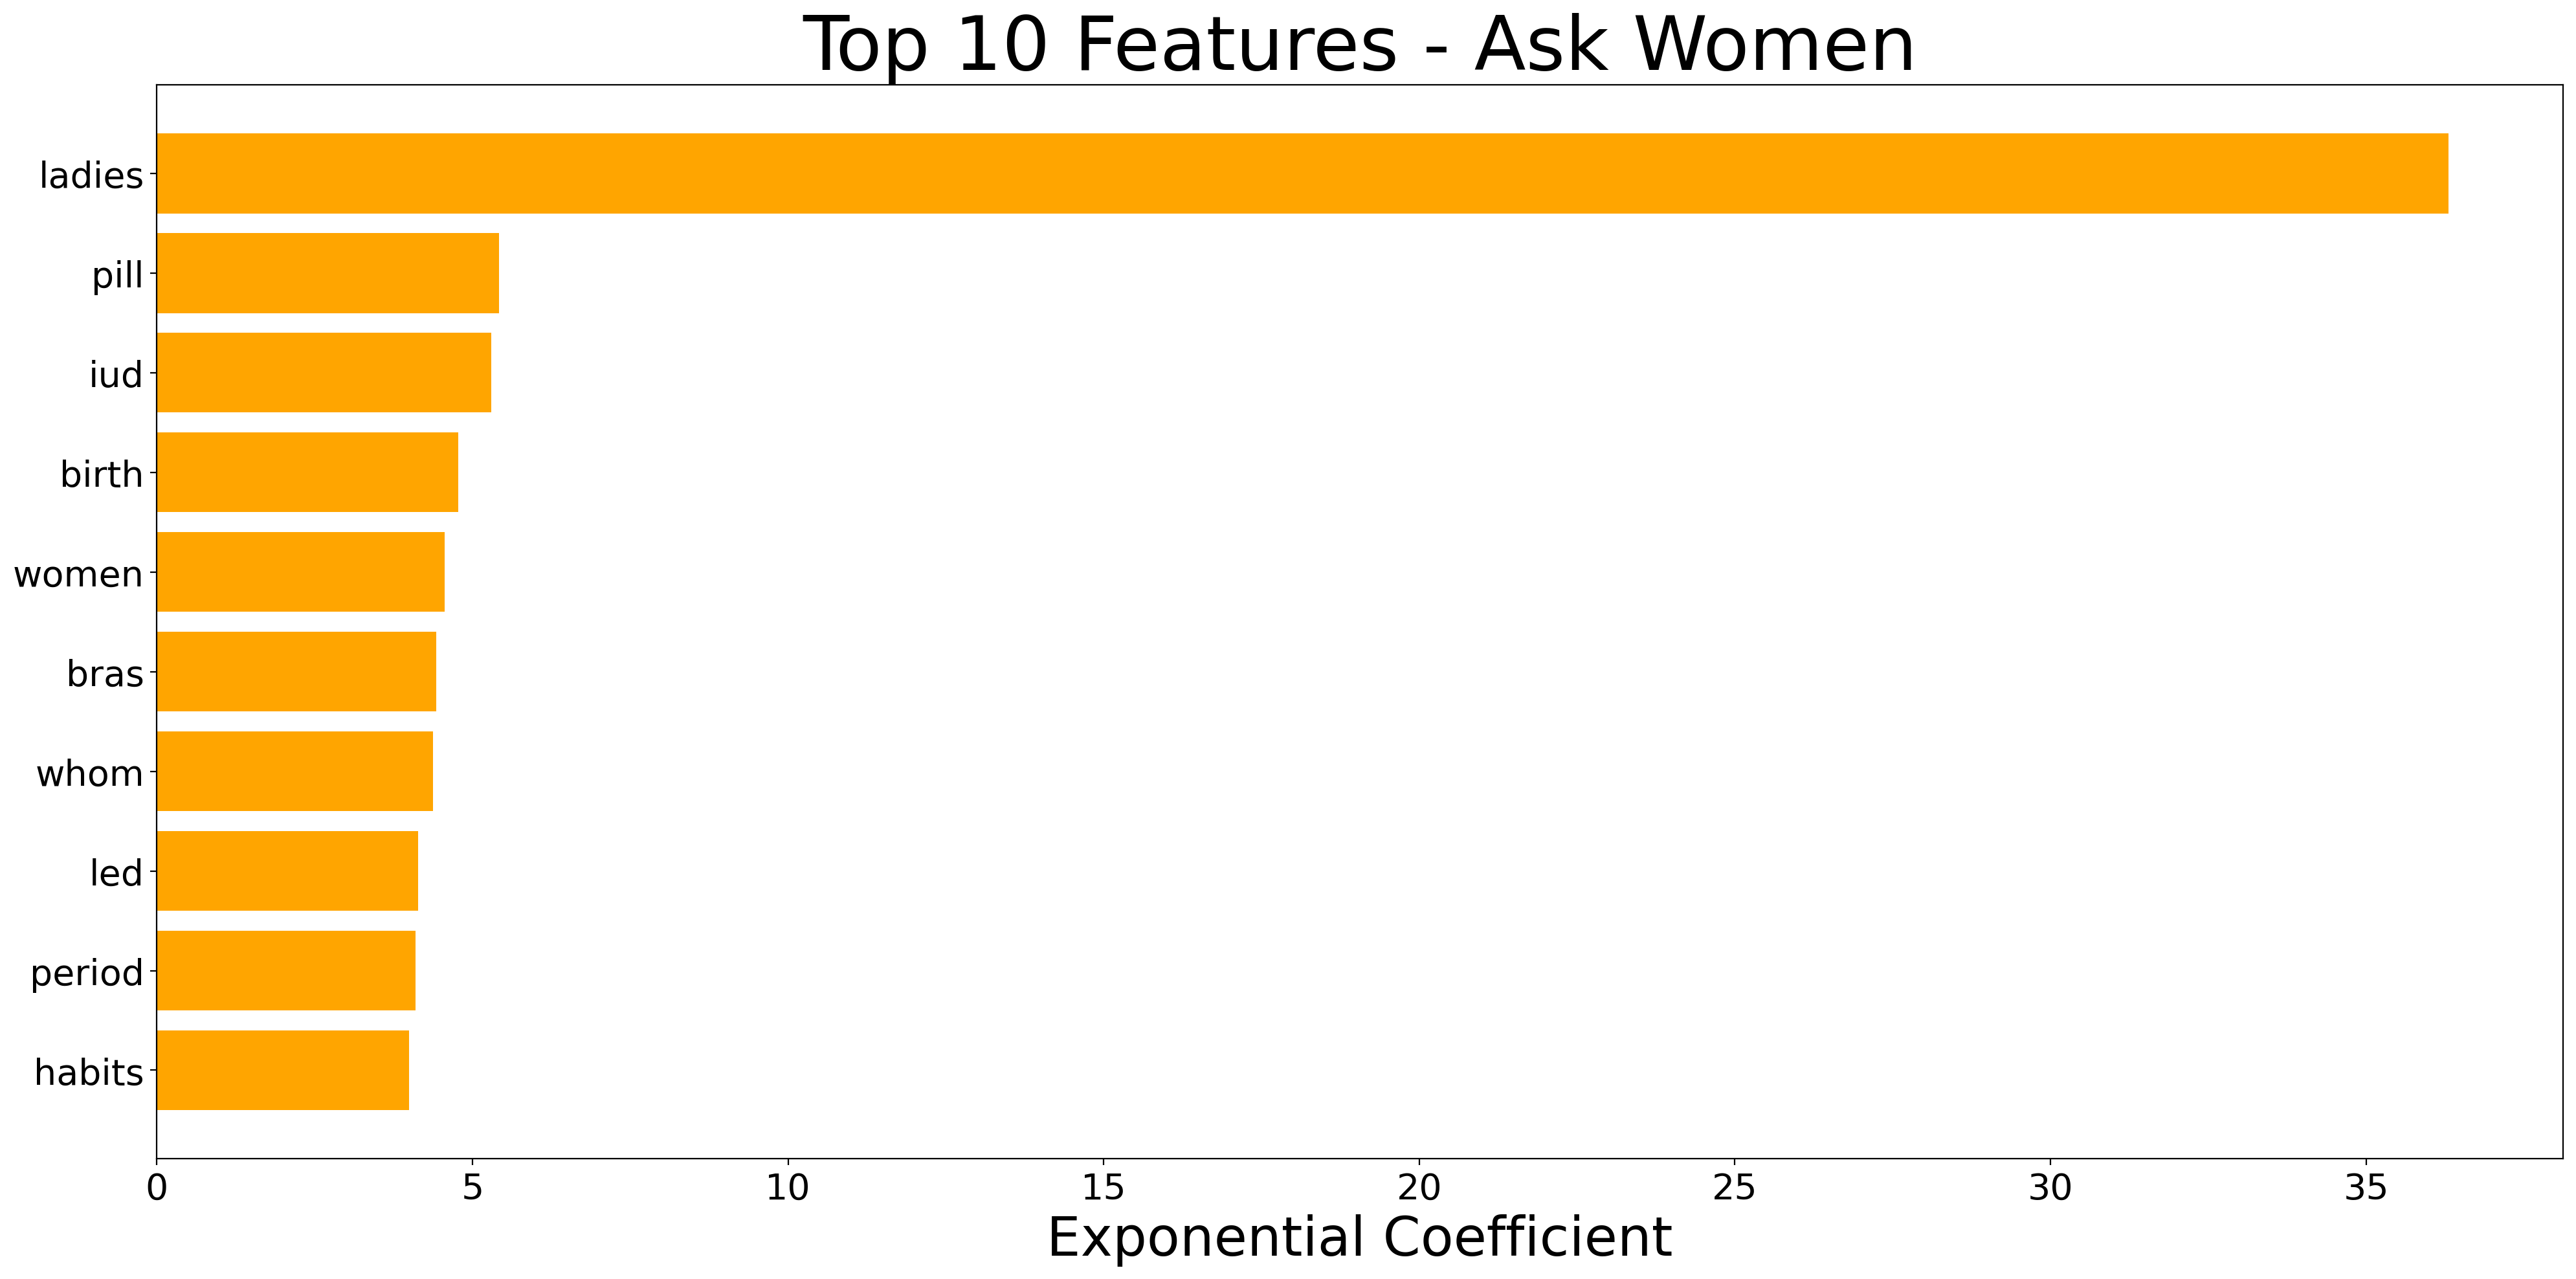

In [80]:
weights = coef_df['exp_coef'].head(10).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = 'orange')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Exponential Coefficient', fontsize=30)
plt.title(f'Top 10 Features - Ask Women', fontsize=42)
plt.tight_layout()

### Graphing Words Most Indicitive of `Ask_Men`

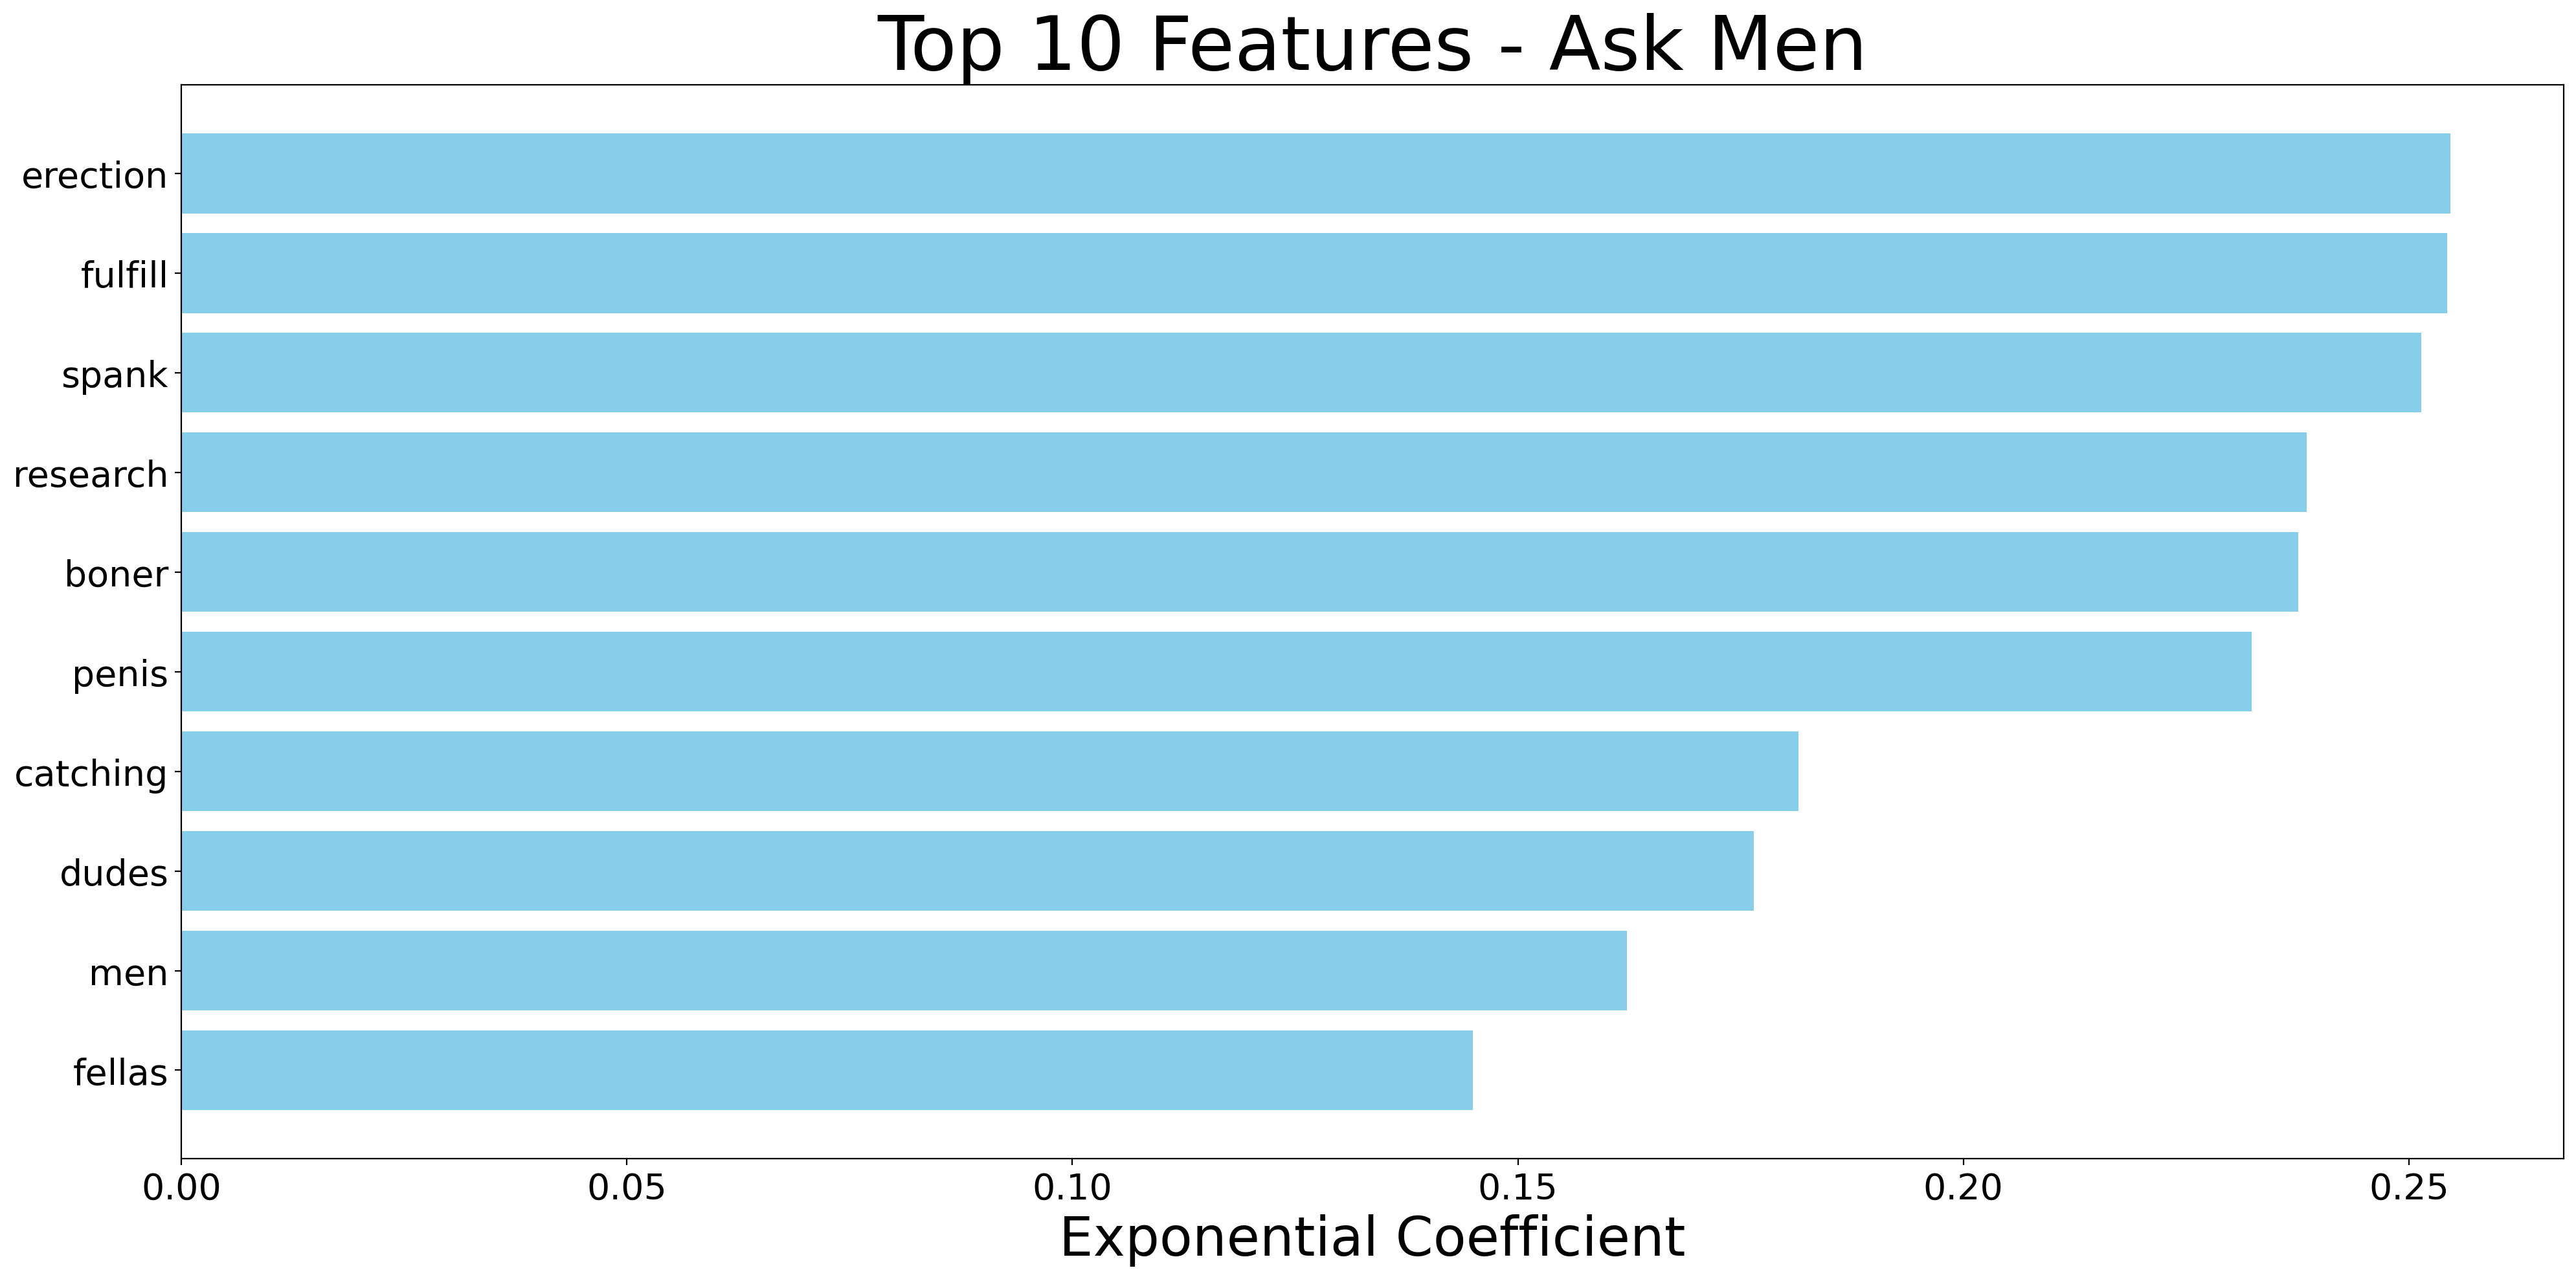

In [81]:
weights = coef_df['exp_coef'].tail(10).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = 'skyblue')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Exponential Coefficient', fontsize=30)
plt.title(f'Top 10 Features - Ask Men', fontsize=42)
plt.tight_layout()

<span style = 'color:green'> Congratulations!!! You're Finished!!!